<a href="https://colab.research.google.com/github/alexmascension/ANMI/blob/main/notebook/T6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 6: Derivación e integración numérica

Este tema lo construyo en parte basado en https://brianheinold.net/notes/An_Intuitive_Guide_to_Numerical_Methods_Heinold.pdf, que proporciona un enfoque bastante más práctico del tema.

In [ ]:
!pip install -r https://raw.githubusercontent.com/alexmascension/ANMI/main/requirements.txt

In [ ]:
from sympy import *
from sympy.matrices import Matrix as mat
from sympy.matrices import randMatrix
from sympy import symbols
import sympy

import numpy as np
from tqdm import tqdm

from scipy.linalg import orth

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [ ]:
from anmi.T5 import polinomio_newton, roots_chebyshev

In [ ]:
from anmi.genericas import norma_p_func, norma_inf_func, matriz_inversa
from anmi.T5 import polinomio_lagrange, polinomio_newton, error_lagrange, error_maximo_estocastico, roots_chebyshev
from anmi.T5 import aitken_neville, interpolacion_hermite, polinomio_generico, esplines

In [ ]:
x, y, z, a, lambda_, h = symbols('x'), symbols('y'), symbols('z'), symbols('a'), symbols('lambda'), symbols('h')

# Derivación numérica

## El problema de la aritmética finita en el cálculo de derivadas

El problema principal del cálculo de derivadas está en que el denominador de la derivada se hace muy pequeño:
$f'(x) = \frac{f(x+h) - f(x)}{h}$

En ese sentido, si empezamos a usar valores de $h$ muy pequeños, podemos acabar teniendo valores de derivada alejados de la realidad. Como ejemplo, vamos a evaluar la derivada de $2x$ en $x=3$, empleando diferentes valores de $h$:

In [ ]:
for n in range(23):
    print(n, (((x+h) ** 2 - x**2) / (h)).subs(h, 10**(-n)).subs(x, 3))

Vemos que para valores de h de $10^{-13}$ para abajo, las derivadas se nos van de madre. Esto es problemático porque para derivadas más complejas el error aumenta y no nos podremos fiar directamente de los resultados. Para mitigar estos problemas en estas secciones trabajaremos con diferentes métodos de aproximación de derivadas.

## Fórmulas de derivación numérica
En esta sección vamos a derivar diferentes métodos de cálculo de derivadas.


## Creando el polinomio de Newton
Una de las opciones para calcular la derivada $n$-ésima es generar un polinomio de grado $n$ y aplicar su derivada $n$ veces. Para ello podemos emplear el método de Newton.

In [ ]:
help(polinomio_newton)

In [ ]:
for i in range(1):
    print(i)

In [ ]:
help(derivacion_polinomio_newton)

In [ ]:
def derivacion_polinomio_newton(f, x0, var=symbols('x'), grado=1, h=0.01):
    x_vals = [x0 + i * h for i in range(grado + 1)]
    y_vals = [f.subs(var, (x0 + i * h)) for i in range(grado + 1)]
    
    # Con esto creamos el polinomio
    p, m = polinomio_newton(x_vals, y_vals, var)
    
    # Ahora lo diferenciamos
    p_diff = p
    for i in range(grado):
        p_diff = p_diff.diff(var)
    
    
    
    return p_diff, p, m

#### EJEMPLO 32

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.05)

In [ ]:
expand(p)

In [ ]:
N(p_diff)

In [ ]:
N(m)

Ahora vamos a jugar con otros valores

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.01)
N(p_diff)

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.001)
N(p_diff)

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.0001)
N(p_diff)

Vemos que con $h$ más pequeños, el valor se asemeja más al verdadero de 0.375

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.0000001)
N(p_diff)

In [ ]:
p_diff, p, m =  derivacion_polinomio_newton(f=sqrt(x), x0=1, var=symbols('x'), grado=3, h=0.000000001)
N(p_diff)

Sin embargo, como antes, si tomamos $h$ extremadamente pequeños, el cálculo se nos va de madre.

## Cálculo de error en derivadas
Muchas veces nos interesa poder hallar el error de aproximación de la derivada, para ver hasta qué punto nos parece una aproximación adecuada.
Recordemos que la expansión de Taylor de $f(x)$ en $x=a$ es:
$$f(x) = f(a) + f'(a)(x-a) + \frac{f^{(2)}(a)}{2!}(x-a)^2 + \frac{f^{(3)}(a)}{3!}(x-a)^3 + \cdots$$
Si sustituimos $x$ for $x+h$ y tomando $a$ como $x-h$, la fórmula anterior queda como:
$$f(x+h) = f(x) + f'(x)h + \frac{f^{(2)}(x)}{2!}h^2 + \frac{f^{(3)}(x)}{3!}h^3 + \cdots$$
Resolviendo para $f'(x)$ tenemos:
$$ f'(x) = \frac{f(x+h) - f(x)}{h} - \frac{f^{(2)}(x)}{2!}h - \frac{f^{(3)}(x)}{3!}h^2 - \cdots$$

Luego el error de aproximación pertenecería a los términos de derivada segunda y superiores. Para simplificar, nos quedamos solo con el término de derivada segunda y se cumple que, para un $c \in [x, x+h]$
$$f'(x) = \frac{f(x+h) - f(x)}{h} - \frac{f^{(2)}(c)}{2!}h$$
De modo que podemos acotar el error.

Esta estrategia de cálculo de error la emplearemos después en otros métodos.

## Derivación con polinomios de Lagrange
Otro método es construyendo polinomios de Lagrange. Recordemos que los polinomios vienen dados por la fórmula:
$$p_n(x) = \sum_{i=0}^n l_i(x)f(x_i)$$
Si aplicamos una derivación a $p_n(x)$ en $\bar{x}_0$ obtenemos el siguiente polinomio:
$$D(f)(\bar{x_0}) = \sum_{i = 0}^n l'_i(\bar{x}_0)f(x_i)$$
$\bar{x_0}$ es un punto cualquiera del intervalo, y puede o no coincidir con alguno de los nodos.

Recordemos que la construcción de $p(x)$ viene dada por la base $\{1, x, \cdots, x^n\}$ y cada termino es $x^j = \sum_{i=0}^n l_i(x)x^j$, de modo que, matricialmente, $p(x)$ se construye como:
$$\begin{bmatrix}
1 & 1 & \cdots & 1 \\
x_0 & x_1 & \cdots & x_n\\
\vdots & \vdots & \ddots & \vdots\\
x_0^n & x_1^n & \cdots & x_n^n\\
\end{bmatrix}
\begin{bmatrix}
l_0\\
l_1\\
\vdots\\
l_n\\
\end{bmatrix} = 
\begin{bmatrix}
1\\
x\\
\vdots\\
x^n
\end{bmatrix}
$$

Si derivamos $r$ veces en $\bar{x}_0$, acabamos con el sistema:
$$\begin{bmatrix}
1 & 1 & \cdots & 1 \\
x_0 & x_1 & \cdots & x_n\\
\vdots & \vdots & \ddots & \vdots\\
x_0^n & x_1^n & \cdots & x_n^n\\
\end{bmatrix}
\begin{bmatrix}
l^{(r)}_0=a_0\\
l^{(r)}_1=a_1\\
\vdots\\
l^{(r)}_n=a_n\\
\end{bmatrix} = 
\begin{bmatrix}
0\\
0\\
\vdots\\
(n)(n-1)\cdots(n-r)\bar{x}_0^{n-r}
\end{bmatrix}
$$

In [ ]:
help(polinomio_lagrange_derivada)

TODO: implementar la función de error

In [ ]:
def polinomio_lagrange_derivada(f, x0, x_vals=None, var=symbols('x'), grado=1, I=[0, 1]):
    ff = Function('f')
    
    if x_vals is None:
        x_vals = np.linspace(I[0], I[1], grado + 1)
    assert len(x_vals) == grado + 1
    
    G = ones(len(x_vals), len(x_vals))
    for row in range(1, len(x_vals)):
        for col in range(len(x_vals)):
            G[row, col] = x_vals[col] ** row
            
    x_mat = Matrix([var ** i for i in range(grado + 1)])
    for _ in range(grado):
        x_mat = x_mat.diff(var)
    
    # Con esto creamos el vector de valores de A
    a = matriz_inversa(G) * x_mat
    
    p, val = S(0), S(0)
    for i in range(grado + 1):
        p += a[i] * ff(x_vals[i])
        val += a[i] * f.subs(var, x_vals[i])
    
    return p, val
    

In [ ]:
polinomio_lagrange_derivada(f=x**3, x0=2, x_vals=[1, 2, 3], var=symbols('x'), grado=2)

## Método de extrapolación de Richardson
Para explicar el método me voy a basar en la explicación de Wikipedia, que generaliza mejor, con cambios de notación. https://en.wikipedia.org/wiki/Richardson_extrapolation

Supongamos que tenemos una función $N(h)$, que la empleamos como aproximación a la derivada en $h=0$, $N(0)$. La función $N(h)$ va a tener una expansión del error del siguiente modo:
$$N(h) = N(0) + a_0h^{k_0} + a_1h^{k_1} + a_2h^{k_2} + \cdots$$

En primer lugar, tomamos un parametro $r$, de modo que podemos sustituir $h$ por $rh$ del siguiente modo:
$$N(rh) = N(0) + a_0(rh)^{k_0} + a_1(rh)^{k_1} + a_2(rh)^{k_2} + \cdots$$

Si multiplicamos por $(r)^{k_0}$ y restamos tenemos que:
$$r^{k_0}N(h) =  N(0) + a_0r^{k_0}h^{k_0} + a_1r^{k_0}h^{k_1} + a_2r^{k_0}h^{k_2} + \cdots$$

$$r^{k_0}N(h) -  N(rh)=  N(0) + (r^{k_0} - r^{k_1})a_1h^{k_1} + (r^{k_0} - r^{k_2})a_2h^{k_2} + \cdots$$

Luego
$$N_1(h) = \frac{r^{k_0}N(h) -  N(rh)}{r^{k_0} - 1}= N(0) + \frac{r^{k_0} - r^{k_1}}{r^{k_0} - 1}a_1h^{k_1} + \frac{r^{k_0} - r^{k_2}}{r^{k_0} - 1}a_2h^{k_2} + \cdots$$

Vemos que ahora tenemos una nueva función, $N_1(h)$, que depende de $a_1h^{k_1} + a_2h^{k_2} + \cdots$, luego hemos reducido su error, ya que $\frac{r^{k_0} - r^{k_1}}{r^{k_0} - 1}$ tiene menos influencia que el orden de $h$. Con iteraciones sucesivas podemos hacer este error tan pequeño como veamos, dentro de la capacidad de error aritmética de $r^nh$ para el ordenador.

Generalizando, la fórmula final es:
$$N_a(r^bh) = \frac{r^{m+a-1}N(r^bh) - N(r^{b+1}h)}{r^{m+a-1} - 1}$$

El valor $m=k_0$ depende de $N(h)$. Si, por ejemplo, $N(h) = \frac{f(x+h) - f(x-h)}{2h}$, considerando los desarrollos de Taylor:
$$f(x+h) = f(x) + f'(x)fh + \frac{1}{2}f''(x)h^2 + \frac{1}{3!}f'''(x)h^3 + \frac{1}{4!}f''''(x)h^4 + \cdots$$
$$f(x-h) = f(x) - f'(x)fh + \frac{1}{2}f''(x)h^2 - \frac{1}{3!}f'''(x)h^3 + \frac{1}{4!}f''''(x)h^4 + \cdots$$

Se tiene que $N(h) = f'(x) + \frac{h^2}{3!}f'''(x) + \frac{h^4}{5!}f^{(5)}(x) +\cdots$, luego $m=2$

Para simplificar los cálulos, se hace un cálculo tabular de todas estas sucesiones. Para ello se hacen los cálculos de la siguiente manera:
$$
\begin{matrix}
h & N(h) & N_1(h) & N_2(h) & N_3(h) \\
rh & N(rh) & N_1(rh) & N_2(rh) & \cdots \\
r^2h & N(r^2h) & N_1(r^2h) & \cdots & \cdots \\
r^3h & N(r^3h) & \cdots & \cdots & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots \\
\end{matrix}
$$

In [ ]:
def derivada_richardson(f, x0=0, r=0.5, h=0.5, x_var=symbols('x'), h_var=symbols('h'), Nf=None, m=None, grado=3):
    if Nf is None:
        Nf = (f.subs(x_var, x0 + h_var) - f.subs(x_var, x0 - h_var))/(2 * h_var)
        m = 2
        
    matriz_r = zeros(grado, grado)
    
    # primero llenamos la matriz con los valores N(rih)
    for row in range(grado):
        rih = r ** row * h
        matriz_r[row, 0] = nsimplify(Nf.subs(h_var, rih),tolerance=1e-10,rational=True)
        
    for col in range(1, grado):
        for row in range(grado - col):
            r_exp = m + col - 1
            matriz_r[row, col] = nsimplify((r**r_exp * matriz_r[row, col - 1] - matriz_r[row+1, col - 1])/(r**r_exp - 1), rational=True)
            
    
    return Nf, matriz_r
    

#### EJERCICIO 60

In [ ]:
f = sin(2*pi*x)
x0, r, h = 0, 0.5, 0.5

Nf, matriz_r = derivada_richardson(f=f, x0=x0, r=r, h=h, grado=3)
Nf

In [ ]:
matriz_r

#### EJEMPLO de HTML

In [ ]:
f = -cos(x)
x0, r, h = 1, 0.5, 1

Nf, matriz_r = derivada_richardson(f=f, x0=x0, r=r, h=h, grado=6)
N(matriz_r)

# Integración numérica

## Cuadratura basada en la interporlación

El método de cuadratura basado en intepolación está basado en el polinomio de Legendre. La metodología es la misma que para la derivada, solo que sustituyendo la derivada con la integral.

$$\begin{bmatrix}
1 & 1 & \cdots & 1 \\
x_0 & x_1 & \cdots & x_n\\
\vdots & \vdots & \ddots & \vdots\\
x_0^n & x_1^n & \cdots & x_n^n\\
\end{bmatrix}
\begin{bmatrix}
l^{(r)}_0=a_0\\
l^{(r)}_1=a_1\\
\vdots\\
l^{(r)}_n=a_n\\
\end{bmatrix} = 
\begin{bmatrix}
\int_a^b 1 dx = b-a\\
\int_a^b x dx =  \frac{b^2-a^2}{2}\\
\vdots\\
\int_a^b x^n dx =  \frac{b^{n+1}-a^{n+1}}{n+1}
\end{bmatrix}
$$

Para el método de newton, el sistema de matrices a resolver es:
$$\begin{bmatrix}
1 & 1 & \cdots & 1 \\
0 & \omega_1(x_1) & \cdots & \omega_1(x_n)\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \omega_n(x_n)\\
\end{bmatrix}
\begin{bmatrix}
l_0\\
l_1\\
\vdots\\
l_n\\
\end{bmatrix} = 
\begin{bmatrix}
1\\
\omega_1\\
\vdots\\
\omega_n
\end{bmatrix}
$$

Donde $\omega_i(x) = (x-x_0)(x-x_1)\cdots(x-x_{i-1})$

Si integramos el rhs tenemos el sistema:
$$\begin{bmatrix}
1 & 1 & \cdots & 1 \\
0 & \omega_1(x_1) & \cdots & \omega_1(x_n)\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \omega_n(x_n)\\
\end{bmatrix}
\begin{bmatrix}
l_0\\
l_1\\
\vdots\\
l_n\\
\end{bmatrix} = 
\begin{bmatrix}
\int_a^b dx\\
\int_a^b \omega_1(x) dx\\
\vdots\\
\int_a^b \omega_n(x) dx
\end{bmatrix}
$$

In [ ]:
help(polinomio_lagrange_integracion)

TODO: implementar la función de error

In [ ]:
def polinomio_lagrange_integracion(f=x, x0=None, x_vals=None, grado=3, var=symbols('x'), I=[0, 1]):
    ff = Function('f')
    
    if x_vals is None:
        x_vals = np.linspace(I[0], I[1], grado)
    
    G = ones(len(x_vals), len(x_vals))
    for row in range(1, len(x_vals)):
        for col in range(len(x_vals)):
            G[row, col] = x_vals[col] ** row
            
    x_mat = nsimplify(Matrix([(I[1] ** (i + 1) - I[0] ** (i + 1))/(i + 1) for i in range(len(x_vals))]), rational=True)

    # Con esto creamos el vector de valores de A
    a = nsimplify(matriz_inversa(G) * x_mat, rational=True)
    
    p, val = S(0), S(0)
    for i in range(len(x_vals)):
        p += a[i] * ff(x_vals[i])
        val += a[i] * f.subs(var, x_vals[i])
    
    return p, val

def polinomio_newton_integracion(f=x, x0=None, x_vals=None, grado=3, var=symbols('x'), I=[0, 1]):
    ff = Function('f')
    
    if x_vals is None:
        x_vals = np.linspace(I[0], I[1], grado)
    
    # Creamos la lista de omegas, que tienen la expresión [w_1, w_2, w_3, etc]
    lista_w = [1, (var - x_vals[0])]
    for x_val in x_vals[1:]:
        lista_w.append(lista_w[-1] * (var - x_val))
    
    G = zeros(len(x_vals), len(x_vals))
    x_mat = zeros(len(x_vals), 1)
    for row in range(len(x_vals)):
        for col in range(row, len(x_vals)):
            if row == 0:
                G[row, col] = 1
            else:
                G[row, col] = lista_w[row].subs(var, x_vals[col])
    
        x_mat[row, 0] = integrate(lista_w[row], (x, I[0], I[1]))
    
    # Con esto creamos el vector de valores de A
    a = matriz_inversa(G) * x_mat
    
    p, val = S(0), S(0)
    for i in range(len(x_vals)):
        p += a[i] * ff(x_vals[i])
        val += a[i] * f.subs(var, x_vals[i])
    
    return p, val

#### EJERCICIO 61

In [ ]:
p, v = polinomio_lagrange_integracion(x_vals=[1, 2, 3], I=[0, 4])
p

In [ ]:
p, v = polinomio_newton_integracion(x_vals=[1, 2, 3], I=[0, 4])
p

#### EJERCICIO 62

In [ ]:
p, v = polinomio_lagrange_integracion(x_vals=roots_chebyshev(2, I=[-1, 1]), I=[-1, 1])
p

## Estimación del error de cuadratura

El error de cuadratura viene definido como 
$$e=\int_a^bf(x)dx - Q(f)$$

Y se tiene que
$$|e| \le \frac{\max_{\xi \in [a,b]} f^{(n+1)}(\xi)}{(n+1)!} \int_a^b|\omega_{n+1}(x)| $$

In [ ]:
def integral_positiva_newton(omega, I, var, x_vals):
    # Esta función la creo para que calcule la integral del valor absoluto. Como las integrales son de la forma (x-x0)(x-x1)(x-x2)(x-x3)...
    # con xi diferentes y en orden creciente, la función va a tomar un valor negativo si el número de términos es impar, y positivo si par
    # para a < x_0, y de ahí va a ir alternando signos. Como pueden surgir casos diferentes (que I[0] sea x_vals[0]) y la casuistica cambia
    # para cada x_i, x_i+1 tomaremos la integral y evaluaremos el signo, para ponerlo a la integral de nuevo.
    integral = S(0)
    
    x_vals_I = [I[0]] + x_vals + [I[1]]
    for i in range(len(x_vals_I) - 1):
        a, b = x_vals_I[i], x_vals_I[i+1]
        integral_i = Integral(omega, (var, a, b)).doit()
        
        if integral_i > 0:
            signo = 1
        elif integral_i < 0:
            signo = -1
        else: # a = b y la integral es cero
            continue
        integral += signo * integral_i
    
    return integral
        
def error_cuadratura_integral(f, var=symbols('x'), x_vals=None, I=[0,1]):
    if x_vals is None:
        x_vals = np.linspace(I[0], I[1], grado)
    
    # Hallamos el primer término, el del máximo de la derivada
    diff_f = f
    for _ in range(len(x_vals)):
        diff_f = diff_f.diff(var)

    max_diff_f = nsimplify(maximum(diff_f, var, Interval(I[0], I[1])) / factorial(len(x_vals)), rational=True)
    
    # Ahora hallamos el de la integral
    omega = S(1)
    for x_val in x_vals:
        omega *= (var - x_val)
    
    int_omega = nsimplify(integral_positiva_newton(omega, I, var, x_vals), rational=True)
    
    e = max_diff_f * int_omega
    
    return e, max_diff_f, int_omega

In [ ]:
#### EJERCICIO 62

In [ ]:
e, max_diff_f, int_omega = error_cuadratura_integral(f=sin(pi*x), x_vals=roots_chebyshev(2, I=[-1, 1]), I=[-1, 1])
e

## Fórmulas cerradas de Newton-Cotes

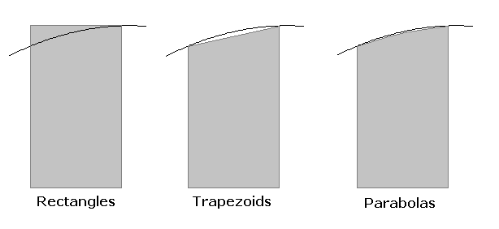

In [ ]:
def formulas_newton_cotes(f, orden=1, x_vals=None,  y_vals=None, I=[0, 1], var=symbols('x')):
    ff = Function('f')
    
    if x_vals is None:
        x_vals = np.linspace(I[0], I[1], orden + 1)
    if y_vals is None:
        y_vals = [f.subs(var, i) for i in x_vals]
    
    G = ones(len(x_vals), len(x_vals))
    for row in range(1, len(x_vals)):
        for col in range(len(x_vals)):
            G[row, col] = x_vals[col] ** row
    
    x_mat = nsimplify(Matrix([(I[1] ** (i + 1) - I[0] ** (i + 1))/(i + 1) for i in range(len(x_vals))]), rational=True)

    # Con esto creamos el vector de valores de A
    a = nsimplify(matriz_inversa(G) * x_mat, rational=True)
    
    Q, val = S(0), S(0)
    for i in range(len(x_vals)):
        Q += a[i] * ff(nsimplify(x_vals[i], rational=True))
        val += a[i] * f.subs(var, x_vals[i])
    
    return Q, val

#### EJERCICIO 63


In [ ]:
Q, val = formulas_newton_cotes(1/(1+x**2), orden=1, I=[-5, 5])
Q

In [ ]:
Q, val = formulas_newton_cotes(1/(1+x**2), orden=2, I=[-5, 5])
Q

In [ ]:
Q, val = formulas_newton_cotes(1/(1+x**2), orden=3, I=[-5, 5])
Q

In [ ]:
Q, val = formulas_newton_cotes(1/(1+x**2), orden=4, I=[-5, 5])
Q

In [ ]:
for i in range(1, 15):
    Q, val = formulas_newton_cotes(1/(1+x**2), orden=i, I=[-5, 5])
    print(i, val)